In [12]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

### Load Augmented data 

In [10]:
df = pd.read_csv('augmented_tickets.csv')
df.sample(5)

,subject,body,type,queue,priority
23,IT Consulting Inquiry,"Dear Customer Support Team, I hope this messag...",Request,Customer Service,low
624,Frequent audio issues with Zoom application,"Dear Customer Support, I am writing to report ...",Incident,Technical Support,low
305,Critical Server Management Problem,"Dear Support Team at IT Consulting Firm, we ha...",Incident,Technical Support,high
1283,Critical: AWS Outage Situation,"Dear Customer Support Team for IT Services,\r\...",Incident,Technical Support,high
422,Urgent: ISR4331 Router Network Connectivity Is...,significantly as Please after the to <acc_num>...,Problem,Technical Support,medium


### Preprocess Data
- Tokenize and lemmatize subject and body 
- Label encoding for type and queue

In [14]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip().lower()
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(preprocessed_tokens)

df['subject_tokenized'] = df['subject'].apply(preprocess_text)
df['body_tokenized'] = df['body'].apply(preprocess_text)

In [43]:
label_encoder_type = LabelEncoder()
label_encoder_queue = LabelEncoder()

df['type_encoded'] = label_encoder_type.fit_transform(df['type'])
df['queue_encoded'] = label_encoder_queue.fit_transform(df['queue'])

df.sample(3)
df.type.unique()

array(['Incident', 'Change', 'Request', 'Problem'], dtype=object)

In [17]:
df['preprocessed_text'] = df['subject_tokenized'] + ' ' + df['body_tokenized']

df_cleaned = df[['preprocessed_text', 'type_encoded', 'queue_encoded', 'priority']]

df_cleaned.sample(5)

,preprocessed_text,type_encoded,queue_encoded,priority
352,request xps exchange 13 malfunctioning dell < ...,0,6,medium
768,exchange request canon pixma mg3620 print qual...,3,6,high
1545,cloud cloud infrastructure optimization dear c...,0,4,medium
1893,request consult service hello write inquir...,3,1,medium
988,assistance consultancy option hello customer s...,3,1,medium


### Data Visualization

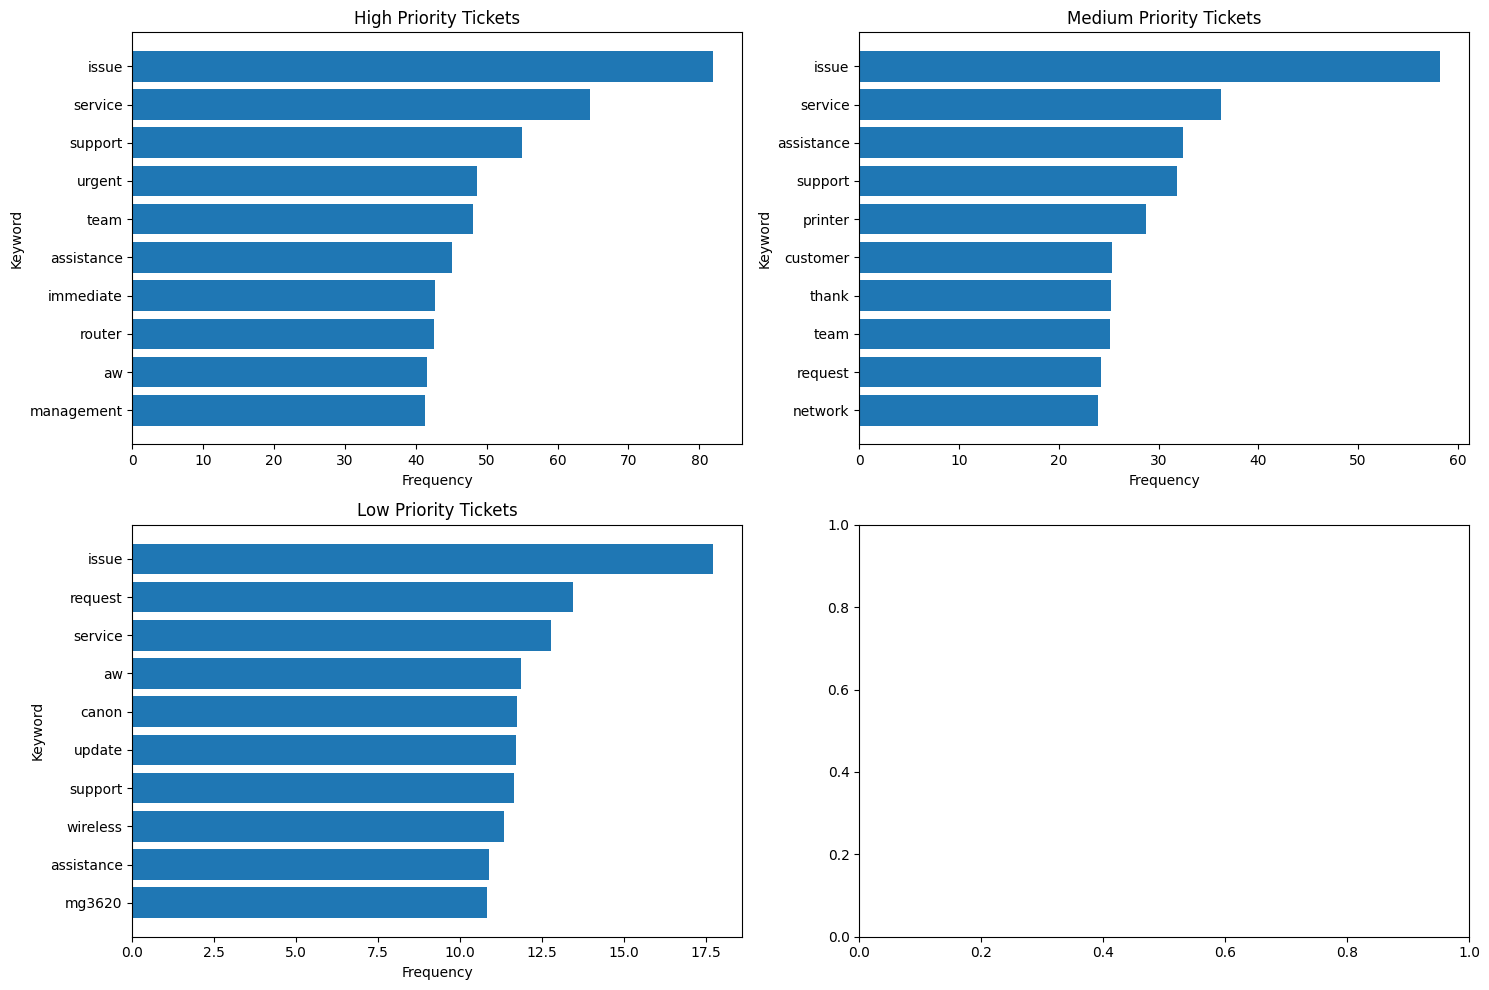

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

high_priority = df_cleaned[df_cleaned['priority'] == 'high']
medium_priority = df_cleaned[df_cleaned['priority'] == 'medium']
low_priority = df_cleaned[df_cleaned['priority'] == 'low']

def create_charts(ax, df, title): 
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['preprocessed_text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()
    
# two on one row and one on the next row
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
create_charts(axs[0, 0], high_priority, 'High Priority Tickets')
create_charts(axs[0, 1], medium_priority, 'Medium Priority Tickets')
create_charts(axs[1, 0], low_priority, 'Low Priority Tickets')
plt.tight_layout()



### Split data into training and test data 

In [30]:
X = df_cleaned[['preprocessed_text', 'type_encoded', 'queue_encoded']]
y = df_cleaned['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training 

In [31]:
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'preprocessed_text')
    ],
    remainder='passthrough'  # Keep numerical columns: type_encoded, queue_encoded
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.97      0.99      0.98       204
         low       1.00      0.95      0.97        57
      medium       0.97      0.96      0.96       145

    accuracy                           0.97       406
   macro avg       0.98      0.97      0.97       406
weighted avg       0.97      0.97      0.97       406



In [47]:
# Example prediction
example = pd.DataFrame({
    'preprocessed_text': ['Outlook is not working. I need to send an email urgently to a client.'],
    'type_encoded': [label_encoder_type.transform(['Problem'])[0]],
    'queue_encoded': [label_encoder_queue.transform(['IT Support'])[0]]
})

priority = pipeline.predict(example)
print(f'Predicted priority: {priority[0]}')

Predicted priority: high
